# LLE (Locally Linear Embedding)

### LLE algorithm attempts to create a low dimensional embedding such that points that are nearby in high dimension remain close in low dimensional embedding.

### The error function is minimized in such a way that `the neighborhood around a point does not changes in lower dimension`.

- Features:
    - __Conformal maps__ (preserve the local angles between the points)
    - It creates the embedding solely based on neighborhood distances __without using global distances__
    - __It assumes that data lies on a smooth manifold__(i.e it does not have holes) and each point and its neighbors lie approximately on a __locally linear patch on the manifold__. The latter assumption gives us the freedom to express each point as a weighted sum of its neighbors.   
    
![](../images/lle.png)

### Calculation

![](../images/lle2.png)

Suppose , we have $$Y_i$$ where $$i\;\in (1,...,n) \;\text{and}\; Y_i\;\in R^D$$


- LLE begins by creating a `neighborhood matrix` (LLE assumes that dataset is large and well-sampled i.e. for every point we have enough to points to create a K-nearest neighborhood), and also not noisy.

- Once neighborhood matrix is defined, each point is `reconstructed as a linear weighted sum of its neighbors (LLE gets it's name from nature of these reconstructions)`.

Error function:

$$\hspace{7em}\mathcal{E}(W) = \Sigma_{i}(Y_i - \Sigma_{j\in N(i)}^k\; W_{ij}Y_j)^2$$

$$\hspace{7em}\Phi(X) = \Sigma_{i}(X_i - \Sigma_{j}W_{ij}X_j)^2$$

where X is the embedding we need to find.

With few suitable constraints, error function can be solved using `eigenvalue decomposition` of $$(I-W)^T(I-W)$$

where I is an identity matrix

In [5]:
from sklearn.neighbors import NearestNeighbors 
from sklearn import datasets, neighbors
import numpy as np
# implement K-nearest neighbor search
# use fisher iris dataset as example
iris_ = datasets.load_iris()

iris = iris_.data
def Nearest_neighbors(X, K, dist_metric = "euclidean", algorithm = "ball_tree"):
    knn = neighbors.NearestNeighbors(K+1, metric = dist_metric, algorithm=algorithm).fit(X)
    _, neareast_neighbors = knn.kneighbors(X)
    return(neareast_neighbors[:,1:])

### Calculation of reconstruction weights  
LLE tries to reconstruct the point Y_i as the weighted average of its neighbors. The reconstruction error is given by  
$\hspace{7em}\mathcal{E}(W) = \Sigma_{i}(Y_i - \Sigma_{j\in N(i)}^k\; W_{ij}Y_j)^2$ where,  
$\hspace{7em}N(i)$ is neighbourhood set of $Y_i$  and  
$\hspace{7em} \Sigma_{j}W_{ij}\; =\; 1.0\;$  


The matrix W has an interesting property it is `invariant to rescalings, rotations and translations`. 

Since

$$sum_{row}(W) = 1$$

so

$$W_{ij}$$ remains unchanged in case of translations.

- Notes:
    - if the number of neighbors is greater than original dimension D, W will not have unique solution and some of the W_ij might be zero. This issue can be handled `by adding a regularization term penalizing the large weights`
    
    
    
Steps to minimize $$\mathcal{E}(W)$$


- For i in 1:n;
    - create a matrix `Z` with all neighbors of `Y_i`  
    - subtract `Y_i` from `Z`  
    - create the local covariance matrix $$C = ZZ^T$$  
    - add a regularized term to avoid C being singular, $$C= C + reg*I$$  
    - solve `CW = 1` for `W`  
    - set `W_{ij} = 0` if j is not a neighbor of i  
    - set $$W = \frac{W}{\sum W}$$  

In [12]:
# calculation of reconstruction weights
from scipy import linalg

def get_weights(X, nearest_neighbors, reg, K):
    n,d = X.shape
    Weights = np.zeros((n,n))
    for i in range(n): 
        Z = X[nearest_neighbors[i],:] - X[i]
        C = np.dot(Z, Z.T)    
        #regularization terms
        trace = np.trace(C)
        if trace >0 :
            R = reg*trace
        else:
            R = reg
        C.flat[::K+1] += R  # Make C is invertible by adding a regularization term to its diagonal values
        weights = linalg.solve(C, np.ones(K).T, sym_pos=True)

        weights = weights/weights.sum()
        Weights[i, nearest_neighbors[i]] = weights
        
    return Weights

### Calculate the embedded data using the weights

Error function:

$$\Phi(X) = \Sigma_{i}(X_i - \Sigma_{j}W_{ij}X_j)^2$$


where:

$$\Sigma_{j}W_{ij} = 1.0$$ 

we can write  

$$\Phi(X) = \Sigma_{i}(\Sigma_{j}W_{ij}(X_i - X_j)^2) = \Sigma_{i}(\Sigma_{j}(X_i - X_j)W_{ij}(X_i - X_j)^T)$$


$$=X^TMX$$


where 

$$M = (I-W)^T(I-W)$$


add few constraints to make sure we have stable solutions  

$$\Sigma_i X_i = 0$$

$$XX^T = I$$

where `I is identity matrix`


Minimizing $$\Phi(X)$$ with the constraints leads to `unique solution in form of eigenvalue decomposition of M`.

We need to `select second to the (p+1)th smallest eigenvectors as the embedded data`

In [6]:
# calculation of the new embedding
from scipy.linalg import eigh

def embedded_data(Weights,d):
    n,_ = Weights.shape
    I = np.eye(n)
    m = (I-Weights)
    M = m.T.dot(m)
    eigvals, eigvecs = eigh(M, eigvals=(1, d), overwrite_a=True)
    index = np.argsort(np.abs(eigvals))
    return(eigvecs[:, index])
    

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)

def LLE(X, K):
    reg =0.001 # regularization param
    nearest_neighbors = Nearest_neighbors(X,K)
    Weights = get_weights(X, nearest_neighbors, reg,K)
    Y = embedded_data(Weights,2)
    return(Y)
test = [154,52, 846,14,39, 563, 186, 436, 93, 91]
def plot(K):
    fig = plt.figure(figsize=(10,8))
    Y = LLE(X , K)
    s = Y[test]
    plt.scatter(Y[:,0],Y[:,1],c=color, cmap=plt.cm.spectral)
    plt.scatter(s[:,0],s[:,1], c="black")
    plt.title("K={}".format(K))

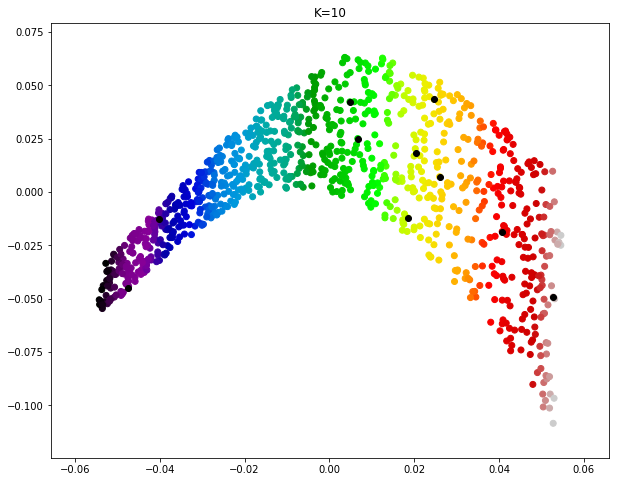

In [30]:
plot(10)

### Drawbacks

Hard to find the neighborhood search parameter.


`Based on the slightly different K LLE can produce completely different results`  

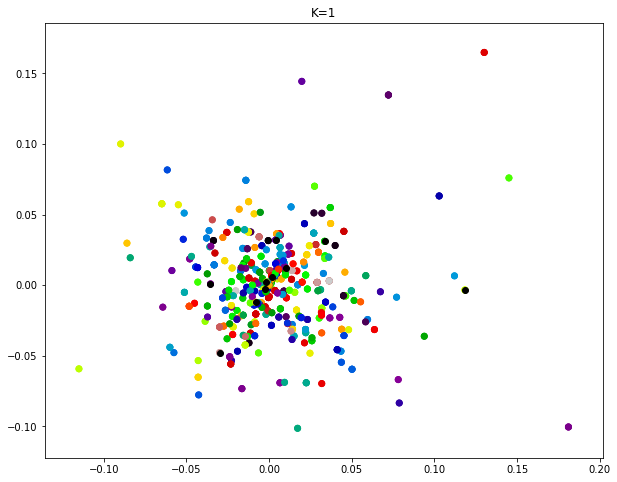

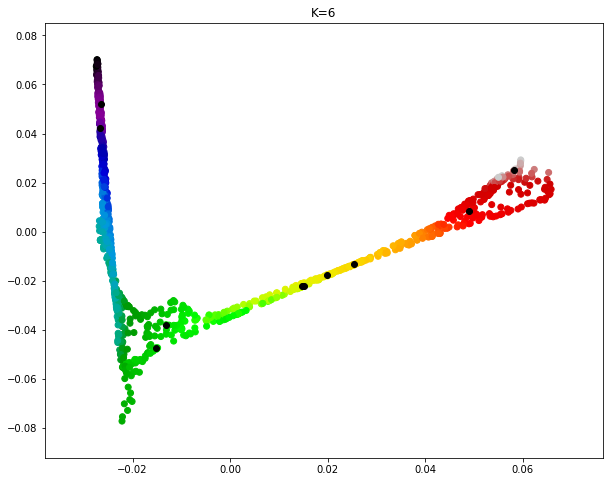

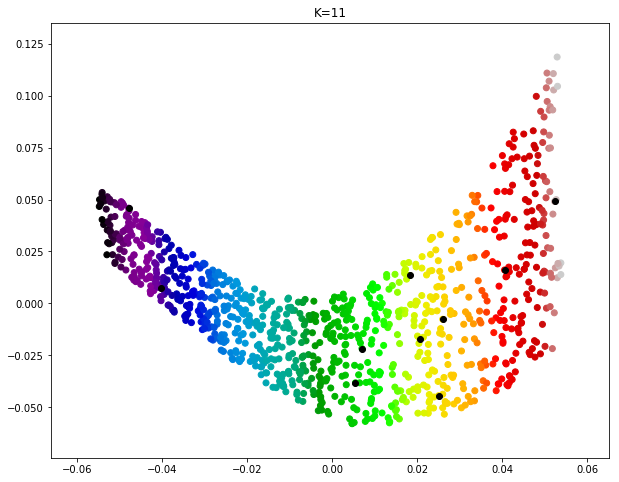

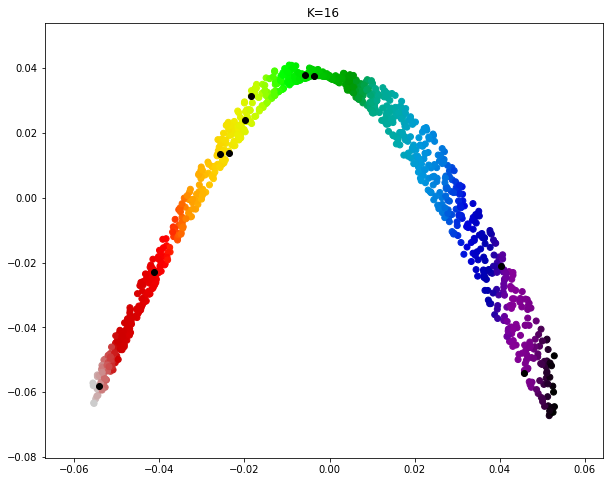

In [31]:
for i in range(1,20,5):
    plot(i)